<a href="https://colab.research.google.com/github/Rahulraj31/Intel-Image-Classification/blob/main/Intel_img_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align=center>Intel Image Classification</h1>

In [1]:
import PIL.Image as Image
import cv2
import numpy as np
import pandas as pd

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers,losses
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

In [2]:
import zipfile

local_zip = '/content/drive/MyDrive/Colab Notebooks/Intel_Img_Class.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
from pathlib import Path 
# Define path to the data directory
#dir_alldata = 

# Path to train directory 
test_data_dir = Path('/content/seg_pred')

# Path to validation directory
val_data_dir = Path("/content/seg_test/seg_test")

# Path to test directory
train_data_dir = Path("/content/seg_train/seg_train")



In [4]:
train_images_dict = {
    'building': list(train_data_dir.glob('buildings/*')) ,   
    'forest': list(train_data_dir.glob('forest/*')),
    'glacier': list(train_data_dir.glob('glacier/*')),
    'mountain': list(train_data_dir .glob('mountain/*')),
    'sea': list(train_data_dir.glob('sea/*')),
    'street': list(train_data_dir.glob('street/*')), 
}


val_images_dict = {
     'building': list(val_data_dir.glob('buildings/*')) ,   
    'forest': list(val_data_dir.glob('forest/*')),
    'glacier': list(val_data_dir.glob('glacier/*')),
    'mountain': list(val_data_dir .glob('mountain/*')),
    'sea': list(val_data_dir.glob('sea/*')),
    'street': list(val_data_dir.glob('street/*')), 
}


labels_dict = {
     'building': "building", 
    'forest': "forest",
    'glacier': "glacier",
    'mountain': "mountain",
    'sea': "sea",
    'street': "street", 
}

In [5]:
img= cv2.imread(str(train_images_dict['building'][0]))
img.shape

(150, 150, 3)

In [6]:
Xtrain, ytrain = [], []
for name,images in train_images_dict.items():#returns key , path for each record
    for image in images:
        img=str(image)
    
        Xtrain.append(img)
        ytrain.append(labels_dict[name])


Fseries = pd.Series(Xtrain, name="filepaths",dtype=str)
Lseries = pd.Series(ytrain, name="labels",dtype=str)
train_data = pd.concat([Fseries,Lseries], axis=1)
train_df = pd.DataFrame(train_data)

print(train_df["labels"].value_counts())

mountain    2512
glacier     2404
street      2382
sea         2274
forest      2271
building    2191
Name: labels, dtype: int64


In [7]:
Xval, yval = [], []
for name,images in val_images_dict.items():#returns key , path for each record
    for image in images:
        img=str(image)
    
        Xval.append(img)
        yval.append(labels_dict[name])


Fseries = pd.Series(Xval, name="filepaths",dtype=str)
Lseries = pd.Series(yval, name="labels",dtype=str)
val_data = pd.concat([Fseries,Lseries], axis=1)
val_df = pd.DataFrame(val_data)

val_df["labels"].value_counts()

glacier     553
mountain    525
sea         510
street      501
forest      474
building    437
Name: labels, dtype: int64

In [8]:
#Generate batches of tensor image data with real-time data augmentation.

image_gen = ImageDataGenerator(rescale = 1./255,
                                
                                   rotation_range = 40,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
    
)
val_gen = ImageDataGenerator(rescale = 1./255,
                                   zoom_range = 0.2,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest'
    
)

train = image_gen.flow_from_dataframe(dataframe= train_df,x_col="filepaths",y_col="labels",
                                      target_size=(150,150),
                                     
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=32,
                                      shuffle=False            #do not shuffle data
                                     )

val = val_gen.flow_from_dataframe(dataframe= val_df,x_col="filepaths", y_col="labels",
                                    target_size=(150,150),
                                   
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=True
                                   )

Found 14034 validated image filenames belonging to 6 classes.
Found 3000 validated image filenames belonging to 6 classes.


In [9]:
classes=list(train.class_indices.keys())
print (classes)

['building', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [10]:
from tensorflow.keras.applications import VGG16

cnn_base = VGG16(include_top = False,
                 weights = 'imagenet',
                 input_shape = (150, 150, 3),
                 classes = 6,
                 classifier_activation = 'softmax')

cnn_base.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [11]:
pretrainedCNN_model = Sequential([
                                     cnn_base,
                                  layers.Flatten(),
                                  layers.Dropout(0.25),
                                  layers.Dense(640, activation = 'relu'),
                                  layers.Dropout(0.25),
                                  layers.Dense(128, activation = 'relu'),
                                  layers.Dropout(0.5),
                                  layers.Dense(64, activation = 'relu'),
                                  layers.Dense(6, activation = 'softmax')  ,  
])

In [12]:

pretrainedCNN_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                            optimizer = keras.optimizers.Adam(0.0001),
                            metrics = ['acc'])

In [13]:
pretrainedCNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 640)               5243520   
_________________________________________________________________
dropout_1 (Dropout)          (None, 640)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               82048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [14]:
len(train_df)

14034

**ModelCheckpoint callback** is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval, so the model or weights can be loaded later to continue the training from the state saved.

In [15]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/content/temp/checkpoint",
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)


In [16]:
History = pretrainedCNN_model.fit(train, validation_data=val, epochs=10,verbose=1,
                                  callbacks=[model_checkpoint_callback])

Epoch 1/10
439/439 [==============================] - 134s 230ms/step - loss: 1.2885 - acc: 0.4738 - val_loss: 0.8661 - val_acc: 0.6683
Epoch 2/10
439/439 [==============================] - 96s 219ms/step - loss: 0.8582 - acc: 0.6605 - val_loss: 0.6357 - val_acc: 0.7530
Epoch 3/10
439/439 [==============================] - 94s 215ms/step - loss: 0.7513 - acc: 0.7101 - val_loss: 0.6962 - val_acc: 0.7240
Epoch 4/10
439/439 [==============================] - 94s 214ms/step - loss: 0.7128 - acc: 0.7279 - val_loss: 0.5245 - val_acc: 0.8117
Epoch 5/10
439/439 [==============================] - 94s 214ms/step - loss: 0.6480 - acc: 0.7542 - val_loss: 0.5324 - val_acc: 0.8010
Epoch 6/10
439/439 [==============================] - 94s 214ms/step - loss: 0.6316 - acc: 0.7603 - val_loss: 0.5121 - val_acc: 0.8027
Epoch 7/10
439/439 [==============================] - 93s 212ms/step - loss: 0.6095 - acc: 0.7668 - val_loss: 0.5355 - val_acc: 0.7923
Epoch 8/10
439/439 [==============================] - 

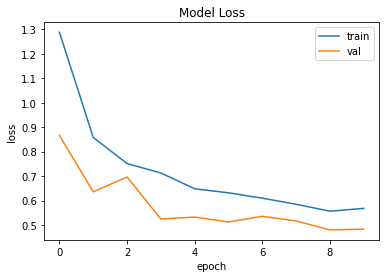

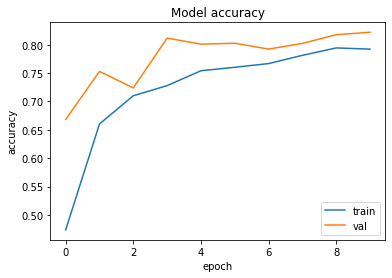

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the loss
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# plot the accuracy
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

In [18]:
pretrainedCNN_model.save('intel_img_model.h5')

In [19]:
test_images= list(test_data_dir.glob('seg_pred/*')) 


In [20]:
test=[]
for image in test_images:
        img=cv2.imread(str(image))
        resize_img=cv2.resize(img,(150,150))
        test.append(resize_img)

In [21]:
test = np.array(test)
test_scaled = test / 255

In [30]:
pred=pretrainedCNN_model.predict(test_scaled)


In [31]:
prediction = [np.argmax(element) for element in pred]
prediction[:10]

[3, 1, 3, 1, 4, 3, 2, 0, 5, 4]

In [32]:
classes=["building", "forest", "glacier","mountain","sea","street"]

## Plotting Results

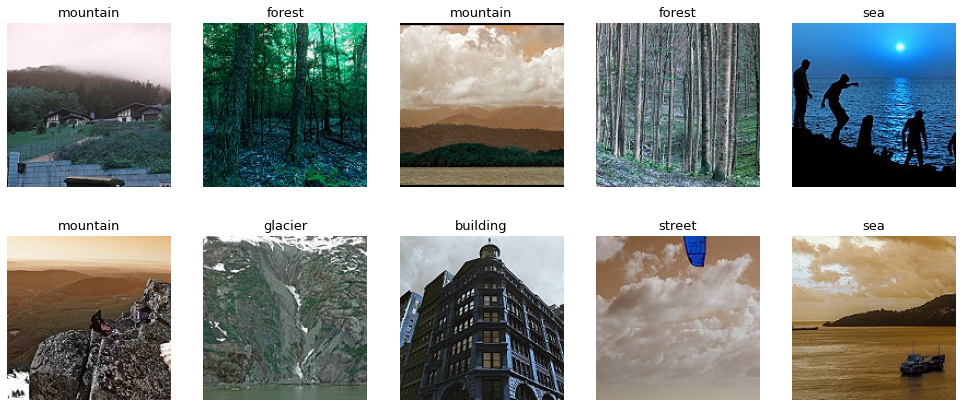

In [79]:
#plotting results
W_grid = 5
L_grid = 2

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))
axes = axes.ravel()
for i in range(0,10):
    # read and display an image with the selected index    
    axes[i].imshow(test[i])
    axes[i].set_title(classes[prediction[i]], fontsize = 13)
    axes[i].axis('off')
plt.subplots_adjust(hspace=-0.7) #negative padding between heights of subplot.
